### Generate Spatial System

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

-

<p>
For this use case, we use Points. First, we simulate two variables having different spatial supports and their locations. S1, S2, loc1, and loc2 respectively. 


</p>

In [2]:
# Simulate S1 and S2 
def simulate_data(num_points1, num_points2): 
    """this function takes in as argument the number of data points, the mean and the standard deviation 
        of the simulated data. By changing the values of the mean and sd you get a different spatial support. 
    """
    np.random.seed(26)
    locations1 = np.random.rand(num_points1, 2) * 100
    locations2 = np.random.rand(num_points2, 2) * 200

    s1 = np.random.normal(50, 10, num_points1)
    s2 = np.random.normal(100, 50, num_points2)

    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_data(100, 150)

<p>


Then we simulate a spatially varying coefficient `ß` that we ideally want to recover. 


</p>

In [3]:
def create_surface(locations):
    """Function to create spatially varying surface with a gradient pattern increasing linearly from 
        bottom left to the top right
    """
    x = locations[:, 0]
    y = locations[:, 1]

    B = x + y

    return B

B = create_surface(loc1)

Let us assume that S1 and S2 are `target support` and `incoming support` respectively. And we want to smooth the incoming support unto the target support such that they are now both on the same spatial support. 

We start by establishing a borrowing threshold. For this, we use 10 nearest neighbors from each observation location in S1 (target support). Essentially we want to find out what are the 10 nearest S2 observations from each calibration location of S1 (target support). 



Next, we have an inner loop where we are looping over the locations of neighbors of y where X is observed. So for each j location of y, we find the corresponding X values.  
We also then compute the distance-based weight between each X value at neighbor `j` and the location `i`. We store the weighted X values in local_X

In [4]:
recovered_betas = np.zeros(len(S1))
n_neighbor = 10
smoothed_X = np.zeros(len(S1))

nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor).fit(loc2) # initialize nearest neighbors to be able to 
                                                             # calculate neighbors of y inside the loop

for i in range(len(S1)): 
    local_X = []
    weights = []

    # Find neighbors of y location i. 
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])  

    # Inner loop - step 4
    for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
        
        # Select incoming support values (S2) from the perspective of each j (location of S1)
        S2_neighbors_j = S2[neighbor_index_S2]

        dist_j_to_i = distances_S1_to_S2[0][j] # Distance from S2 neighbor j to S1 location i
        weight = np.exp(-dist_j_to_i)
        
        # Append the smoothed S2 and weights
        local_X.append(S2_neighbors_j)
        weights.append(weight)
        
    # Convert to arrays for regression
    local_X = np.array(local_X)
    weights = np.array(weights)

    # store the single smoothed X variable
    smoothed_X[i] = np.sum(local_X * weights) / np.sum(weights)

# get true y 
y = np.multiply(B, smoothed_X)

# compute local regression
nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor).fit(loc1)

for i in range(len(S1)):
    # find neigbors in target support
    distances, indices = nbrs_S1.kneighbors([loc1[i]])

    # obtain smoothed_X and y values of neighbors
    X_neighbors = smoothed_X[indices[0]]
    y_neighbors = y[indices[0]]    

    # Compute weights based on distances
    weights = np.exp(-distances[0])
    W = np.sqrt(weights)

    # Prepare weighted datasets
    X_weighted = (X_neighbors * W).reshape(-1, 1)
    y_weighted = y_neighbors * W
    
    # Fit weighted linear regression
    model = LinearRegression()
    model.fit(X_weighted, y_weighted)

    # Store recovered beta
    recovered_betas[i] = model.coef_[0]

# Compare the first 5 true and recovered betas
B[:15], recovered_betas[:15]

(array([ 82.73264319, 155.75183977, 105.84834541,  76.56973866,
         93.40737388,  71.85715053, 104.37054741,  56.3212451 ,
        187.56198378, 105.36671994, 119.03337692, 113.77213613,
        159.48991106, 101.55497791, 135.07674376]),
 array([ 82.84561087, 155.72877883, 105.81345538,  76.24630855,
         93.39817609,  71.81741049, 104.3981669 ,  56.55076956,
        187.9178017 , 105.37869897, 119.07242547, 113.45636198,
        159.84977835, 101.55791615, 135.04179299]))

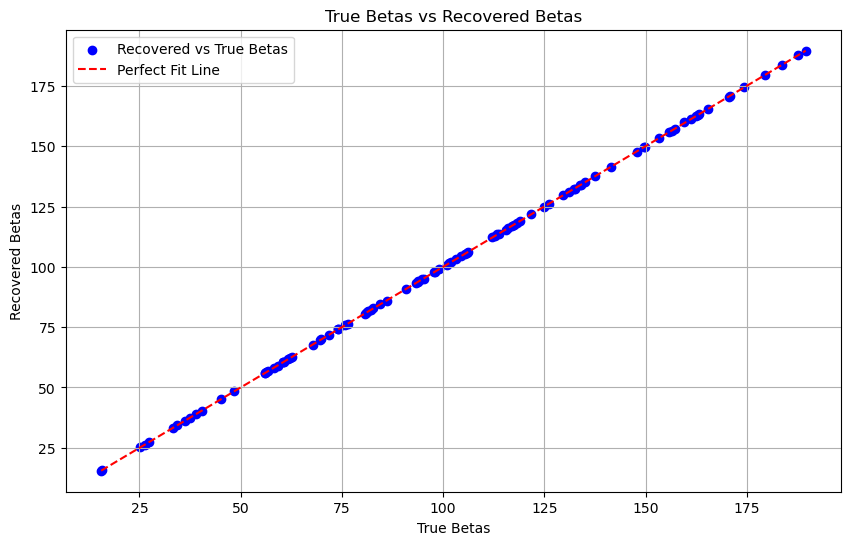

In [5]:
import matplotlib.pyplot as plt

# Plotting the true betas vs. the recovered betas

plt.figure(figsize=(10, 6))

# Scatter plot of true vs. recovered betas
plt.scatter(B, recovered_betas, color='blue', label='Recovered vs True Betas')

# Plotting a reference line for perfect recovery
plt.plot([min(B), max(B)], [min(B), max(B)], color='red', linestyle='--', label='Perfect Fit Line')

plt.xlabel('True Betas')
plt.ylabel('Recovered Betas')
plt.title('True Betas vs Recovered Betas')
plt.legend()
plt.grid(True)
plt.show()